# 局部自适应阈值分割方法

In [2]:
#coding:utf-8
import numpy as np
%matplotlib  inline
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from scipy.misc import imread, imresize, imsave

In [3]:
src = cv2.cvtColor(cv2.imread('../datas/road.jpg'),cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(src,cv2.COLOR_RGB2GRAY)

In [32]:
rows,cols = gray.shape

In [14]:
def average_filter(gray,ksize):
    rows,cols = src.shape[0],src.shape[1]
    n_odd = ksize
    if ksize % 2 == 1:
        n_odd = ksize - 1
    dst = np.zeros_like(gray).astype(np.float32)
    gray_f = gray.astype(np.float32)
    
    for i in range(n_odd // 2,rows - n_odd):
        for j in range(n_odd // 2,cols - n_odd):
            avg = 0.0
            for m in range(ksize):
                for k in range(ksize):
                    tmp = gray[i + (k - (n_odd // 2)),j + (m - (n_odd // 2))]
                    avg += (1.0 / (ksize * ksize)) * tmp
            dst[i,j] = avg
    dst[dst < 0] = 0
    dst[dst > 255] = 255
    return dst.astype(np.uint8)

In [15]:
# dst_avg = average_filter(gray,3)

## 1.计算图像均值滤波

可以通过BoxFilter来替代

In [23]:
dst_avg = cv2.boxFilter(gray,-1,(3,3))

Text(0.5,1,'Average Filter')

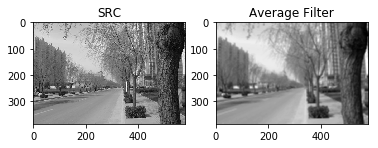

In [22]:
plt.subplot(121)
plt.imshow(gray,'gray')
plt.title('SRC')
plt.subplot(122)
plt.imshow(dst_avg,'gray')
plt.title('Average Filter')

## 2.计算图像梯度图

In [26]:
fx,fy = np.gradient(dst_avg)
F = np.sqrt(fx ** 2 + fy ** 2)

Text(0.5,1,'Gradient ')

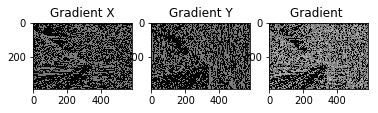

In [28]:
plt.subplot(131)
plt.imshow(cv2.convertScaleAbs(fx),'gray')
plt.title('Gradient X')
plt.subplot(132)
plt.imshow(cv2.convertScaleAbs(fy),'gray')
plt.title('Gradient Y')
plt.subplot(133)
plt.imshow(cv2.convertScaleAbs(F),'gray')
plt.title('Gradient ')

## 3.具有局部最大阈值的点

通过Laplacian算子，可以找到具有局部最大阈值的点这些点的原始灰度值就是候选的局部阈值

In [29]:
dst_lapalican = cv2.Laplacian(dst_avg,0)

Text(0.5,1,'Laplacian')

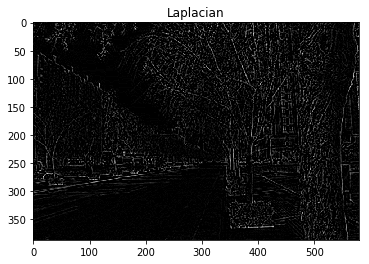

In [31]:
plt.imshow(dst_lapalican,'gray')
plt.title('Laplacian')

## 4.采样候选点，灰度值替换

In [56]:
P_new = np.zeros_like(gray)
idx = (dst_lapalican == 0)
P_new[idx] = gray[idx]
P_new = P_new.astype(np.float32)
print(P_new)

[[184. 151.   0. ...   0.   0.   0.]
 [168.   0.   0. ... 197.   0.   0.]
 [172.   0.   0. ... 226.   0.   0.]
 ...
 [139.   0. 136. ... 136. 135. 135.]
 [142. 140.   0. ...   0.   0.   0.]
 [144. 142.   0. ... 125.   0.   0.]]


Text(0.5,1,'Step 4')

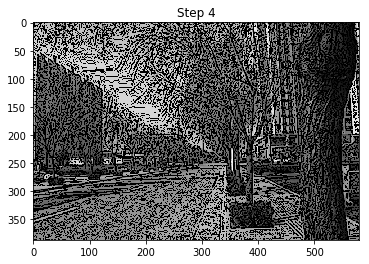

In [57]:
plt.imshow(P_new.astype(np.uint8),'gray')
plt.title('Step 4')

## 5.插值灰度点，得到阈值表面

In [58]:
GradTresh=20
InterTreshhold=10e-6
MaxInterNum=15500
Residual=InterTreshhold+1
InterNum=0

In [73]:
while Residual > InterTreshhold:
    if InterNum > MaxInterNum:
        break
    InterNum=InterNum+1
    P_last = P_new.copy()
    R = cv2.Laplacian(P_new.astype(np.uint8),0)
    P_new = P_new + R.astype(np.float32)/ 4.0
    Residual = np.mean(np.abs(P_new - P_last))
P_new = P_new.astype(np.uint8)
print(Residual,InterTreshhold)

8.910273e-06 1e-05


## 6.阈值表面分割图像

In [74]:
bw = np.zeros_like(gray)
bw[gray > P_new] = 255

Text(0.5,1,'First Segment Result')

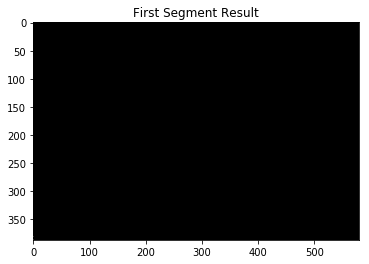

In [78]:
plt.imshow(P_new.astype(np.uint8),'gray')
plt.title('First Segment Result')

In [76]:
print((P_new == 0).all())

False


In [77]:
print(P_new)

[[249 249 249 ... 249 249 249]
 [249 249 249 ... 249 249 249]
 [249 249 249 ... 249 249 249]
 ...
 [249 249 249 ... 249 249 249]
 [249 249 249 ... 249 249 249]
 [249 249 249 ... 249 249 249]]


参考：

[1].https://blog.csdn.net/qq_19531479/article/details/79649304

[2].https://github.com/radishgiant/ThresholdAndSegment